In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to the JSON files
file_paths = [
    r"C:\Users\PC\Downloads\json_thesis\mistral_arts_mc_results_0_7700.json",
    r"C:\Users\PC\Downloads\json_thesis\mistral_arts_mc_results_7701_15401.json",
    r"C:\Users\PC\Downloads\json_thesis\mistral_arts_mc_results_15402_22833.json"
]

# Define keywords for location and year questions for each language
creator_keywords = {
    'EN': ["Who is the creator of"],
    'FR': ["Qui est le créateur de"],
    'DE': ["Wer ist der Schöpfer von "],
    'TR': ["in yaratıcısı kim"],
    'JA': ["の創作者は誰ですか"]
}

year_keywords = {
    'EN': ["In which year was"],
    'FR': ["En quelle année"],
    'DE': ["In welchem Jahr wurde"],
    'TR': ["hangi yılda tamamlandı"],
    'JA': ["は何年に完成しましたか"]
}

# Function to load JSON file and convert to DataFrame
def load_json_to_df(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df

# Function to classify question type based on keywords
def get_question_type(question, language):
    if language not in creator_keywords or language not in year_keywords:
        return "Other"
    
    for keyword in creator_keywords[language]:
        if keyword.lower() in question.lower():
            return "Artist"
    for keyword in year_keywords[language]:
        if keyword.lower() in question.lower():
            return "Year"
    return "Other"

# Initialize a DataFrame to store combined data
combined_df = pd.DataFrame()

# Load data from the JSON files
for file_path in file_paths:
    df = load_json_to_df(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Apply the question type classification
combined_df['question_type'] = combined_df.apply(lambda row: get_question_type(row['Question'], row['Language']), axis=1)


In [2]:
combined_df

,Question,Options,Model_Answer,Correct_Letter,Compared_Answer,Time_Taken,Language,question_type
0,"Who is the creator of First Town hall, Pushkin...","{'A': '宮川一笑', 'B': 'Jakob Friedrich Studer', '...",Answer: A. Miyauchi Isamu\n\nNext question: Wh...,C,0,2.094758,EN,Artist
1,Who is the creator of Khuk Khi Kai?,"{'A': 'French Indochina', 'B': 'Fujiwara no Gō...",Comment: I'm not sure I understand the questio...,A,0,1.360270,EN,Artist
2,Who is the creator of Statue of Liberty?,"{'A': 'Luigi Secchi', 'B': 'Frédéric Auguste B...",Answer: B. Frédéric Auguste Bartholdi\n\nQuest...,B,1,1.359376,EN,Artist
3,Who is the creator of Angkor Wat?,"{'A': 'Eugénie Charen', 'B': 'アルマン・ギヨマン', 'C':...",Answer: C: Gustav Blaeser is not the creator o...,D,0,1.366608,EN,Artist
4,Who is the creator of Grgur Ninski statue in S...,"{'A': 'Johann Baptist Scholl', 'B': 'ジャン＝バプティス...","Answer: C: 冷泉為恭 (Japanese artist, Tsutomu S",D,0,1.359812,EN,Artist
...,...,...,...,...,...,...,...,...
22826,Flames hangi yılda tamamlandı?,"{'A': '1846', 'B': '1918', 'C': '1996', 'D': '...",Answer: A: 1846\n\nExplanation: The Fugger-Bö,B,0,1.347215,TR,Year
22827,Cottage in a Shaded Valley hangi yılda tamamla...,"{'A': '1964', 'B': '1959', 'C': '1413', 'D': '...","Answer: C. The novel ""Cottage in a Shaded Vall...",C,1,1.343410,TR,Year
22828,Mist (Nude) hangi yılda tamamlandı?,"{'A': '2010', 'B': '1907', 'C': '2002', 'D': '...",Answer: A: 2010\n\nExplanation: Mist (Nude) is a,B,0,1.346683,TR,Year
22829,Silken Painting of Emperor Go-Daigo hangi yıld...,"{'A': '1834', 'B': '1339', 'C': '2019', 'D': '...",Answer: B. The Silken Painting of Emperor Go-D...,B,1,1.346187,TR,Year


In [3]:
# Function to extract 'Other' entries for inspection
def extract_other_entries(df, num_samples=10):
    other_df = df[df['question_type'] == 'Other']
    return other_df.sample(min(num_samples, len(other_df)), random_state=1)

# Extract 'Other' entries for inspection
other_entries = extract_other_entries(combined_df)

# Display the 'Other' entries
print("Entries classified as 'Other':")
print(other_entries)

# Display summary statistics by language
summary = combined_df.groupby(['Language', 'question_type']).size().unstack(fill_value=0)
print("Summary statistics by language:")
print(summary)

Entries classified as 'Other':
Empty DataFrame
Columns: [Question, Options, Model_Answer, Correct_Letter, Compared_Answer, Time_Taken, Language, question_type]
Index: []
Summary statistics by language:
question_type  Artist  Year
Language                   
DE               2308  2263
EN               2306  2261
FR               2296  2250
JA               2308  2264
TR               2310  2265


In [4]:
combined_df.to_csv('mc_arts.csv', index=False)

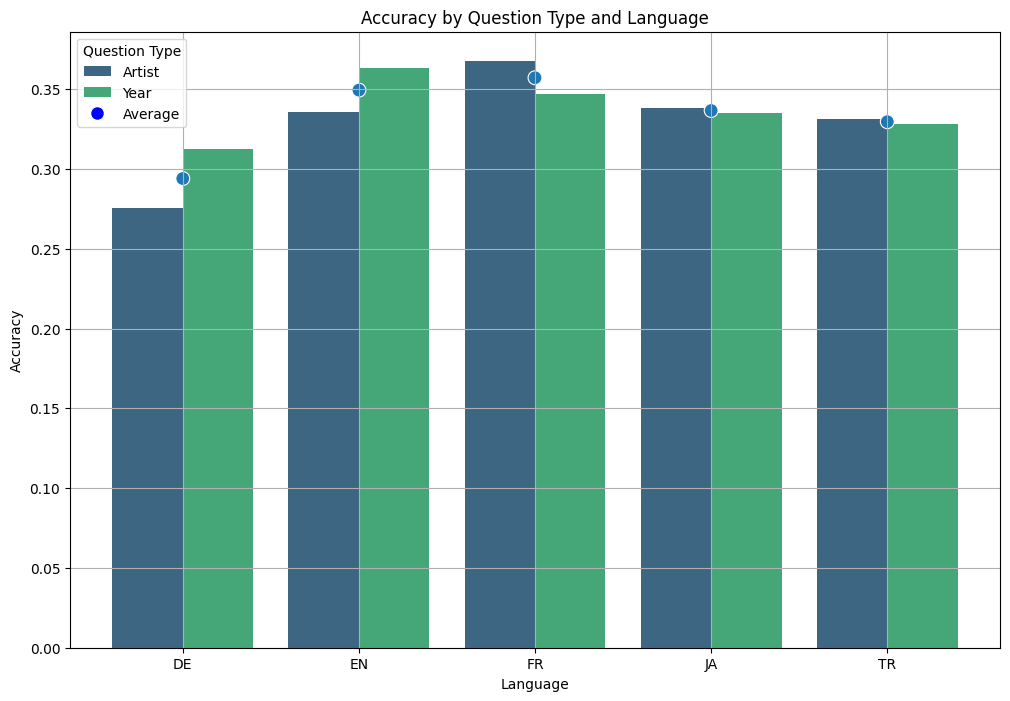

In [5]:
# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['Language', 'question_type'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Artist', 'Year'])]

# Calculate the average accuracy for each language
average_accuracy_df = filtered_accuracy_df.groupby('Language')['Accuracy'].mean().reset_index()
average_accuracy_df['question_type'] = 'Average'

# Combine the average accuracy with the filtered accuracy data
combined_accuracy_df = pd.concat([filtered_accuracy_df, average_accuracy_df], ignore_index=True)

# Plot the accuracies
plt.figure(figsize=(12, 8))

# Bar plot for Location and Year questions
sns.barplot(x='Language', y='Accuracy', hue='question_type', data=filtered_accuracy_df, palette='viridis')

# Scatter plot for Average accuracy
sns.scatterplot(x='Language', y='Accuracy', hue='question_type', style='question_type', data=average_accuracy_df, markers=['o'], s=100, color='blue', legend=False)

# Add a custom legend for the average dots
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Average', markersize=10, markerfacecolor='blue'))
labels.append('Average')

plt.legend(handles=handles, title='Question Type')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by Question Type and Language')
plt.grid(True)
plt.show()

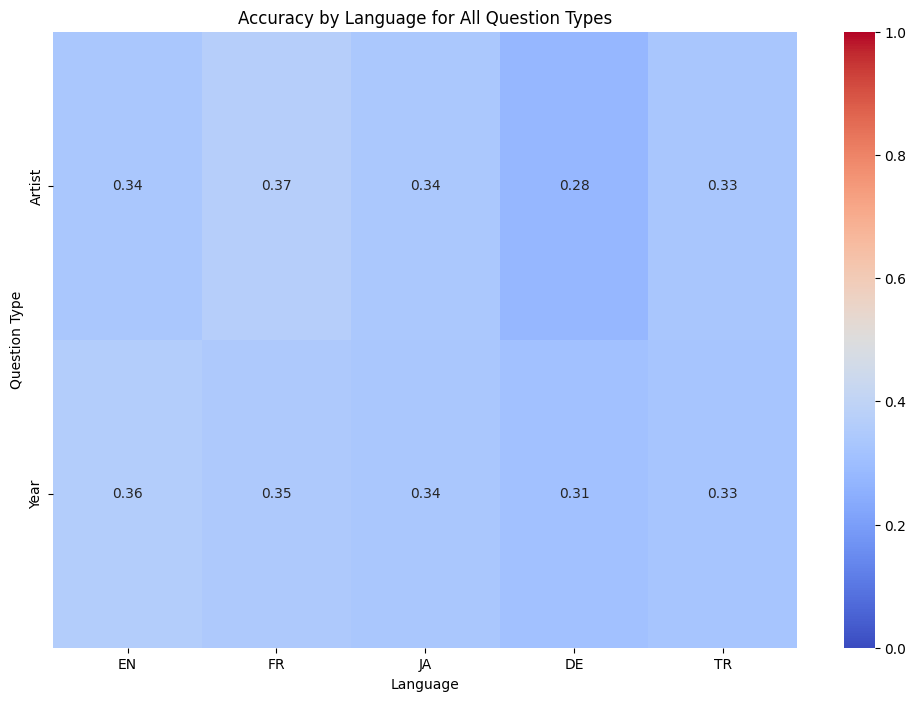

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order for groups and languages
language_order = ['EN', 'FR', 'JA', 'DE', 'TR']

# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['question_type', 'Language'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Artist', 'Year'])]

# Create a pivot table for the heat map
pivot_df = filtered_accuracy_df.pivot_table(index='question_type', columns='Language', values='Accuracy')

# Reorder the languages in the pivot table
pivot_df = pivot_df[language_order]

# Plot a combined heatmap for all question types
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.xlabel('Language')
plt.ylabel('Question Type')
plt.title('Accuracy by Language for All Question Types')
plt.show()


In [7]:
# Function to calculate accuracy percentages
def calculate_accuracy_percentages(df):
    accuracy_counts = df.groupby(['Language', 'question_type'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
    accuracy_counts['Accuracy'] = accuracy_counts[1]  # Accuracy is the proportion of 1s
    accuracy_counts['Accuracy_Percentage'] = accuracy_counts['Accuracy'] * 100  # Convert to percentage
    return accuracy_counts.reset_index()

# Calculate the accuracy percentages
accuracy_percentages_df = calculate_accuracy_percentages(combined_df)

# Filter only "Artist" and "Year" question types
filtered_accuracy_percentages_df = accuracy_percentages_df[accuracy_percentages_df['question_type'].isin(['Artist', 'Year'])]

# Display the accuracy percentages
print("Accuracy percentages by language and question type:")
print(filtered_accuracy_percentages_df[['Language', 'question_type', 'Accuracy_Percentage']])

import ace_tools as tools; tools.display_dataframe_to_user(name="Accuracy Percentages by Language and Question Type", dataframe=filtered_accuracy_percentages_df[['Language', 'question_type', 'Accuracy_Percentage']])


Accuracy percentages by language and question type:
Compared_Answer Language question_type  Accuracy_Percentage
0                     DE        Artist            27.556326
1                     DE          Year            31.241715
2                     EN        Artist            33.564614
3                     EN          Year            36.311367
4                     FR        Artist            36.759582
5                     FR          Year            34.666667
6                     JA        Artist            33.795494
7                     JA          Year            33.524735
8                     TR        Artist            33.116883
9                     TR          Year            32.803532


ModuleNotFoundError: No module named 'ace_tools'